In [15]:
import numpy as np, cv2
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from scipy.spatial.distance import pdist
from matplotlib import rcParams
rcParams.update({'font.size': 15})

# Dendrogram
***
* Dendrogram shows hierarchical ordering of subclusters of bottom-up (agglomerative) clustering algorithms.

Clustering itself occurs during _linkage_ procedure, where disntance between elements are analyzed.<br> 
If method 'single' is selected, agglomeration begins with two elements that are the closest.<br>
Mind that _'closeness'_ can be calculated using different norms. Euclidean norm or L2 is the most common.<br>
Two closest points are merge into to one mini-cluster and calculated procedes forward.
***

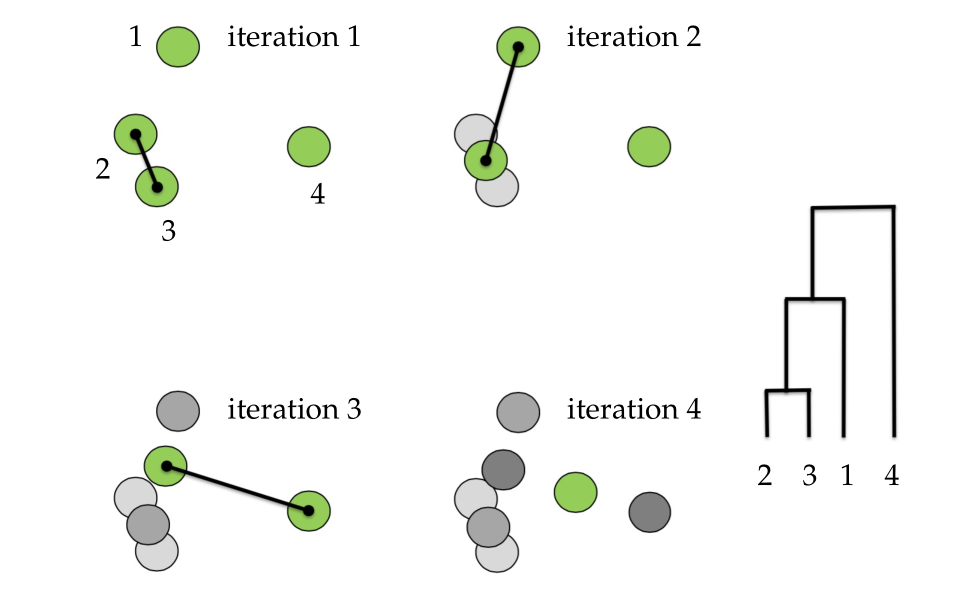



## Generate Data
(Same data as in part 02)

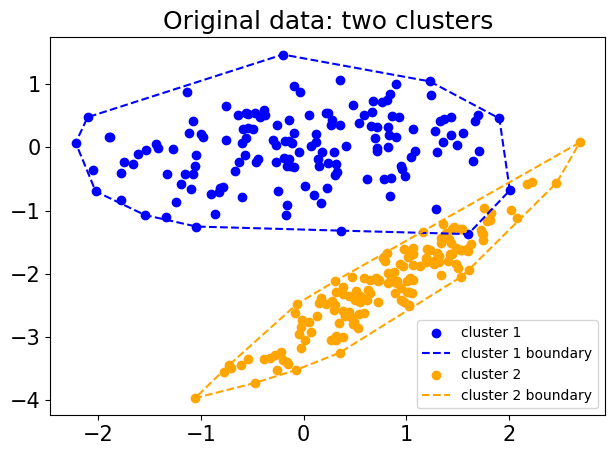

In [16]:
n1 = 50
n2 = 100
np.random.seed(69)

scale_1 = np.array([[0.9,0],[0,0.5]])
cluster_1 = scale_1 @ np.random.randn(2,n1+n2)   # [x,y] : (2,N)
scale_2 = np.array([[1,0],[0,0.2]]) 
cluster_2 = scale_2 @ np.random.randn(2,n1+n2)

theta = np.pi/4
R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
offset = np.array([[1,-2]]).T
cluster_2 = R @ cluster_2 + offset

hull1 = cv2.convexHull(np.float32(cluster_1.T))
hull2 = cv2.convexHull(np.float32(cluster_2.T))
hull1 = np.vstack((hull1,hull1[[0]]))       # add start point to end
hull2 = np.vstack((hull2,hull2[[0]]))       # so contour closes

fig, ax = plt.subplots(1,tight_layout=True)
ax.scatter(*cluster_1, label= 'cluster 1', c = 'b')
ax.plot(*hull1.T.reshape(2,-1), c = 'b', ls = '--', label= 'cluster 1 boundary')
ax.scatter(*cluster_2, label= 'cluster 2', c = 'orange')
ax.plot(*hull2.T.reshape(2,-1), c = 'orange', ls = '--', label= 'cluster 2 boundary')
ax.set_title('Original data: two clusters')
plt.legend(ncols = 1, loc='lower right', fontsize = 10);

In [17]:
#np.random.seed(2)
cluster_1b = cluster_1.copy()#;np.random.shuffle(cluster_1b)
cluster_2b = cluster_2.copy()#;np.random.shuffle(cluster_2b)
start = 40
train_1 = cluster_1b.T[start:start+n1]
train_2 = cluster_2b.T[start:start+n1]
print(train_1.shape)
hull1t = cv2.convexHull(np.float32(train_1))
hull2t = cv2.convexHull(np.float32(train_2))
hull1t = np.vstack((hull1t,hull1t[[0]]))       # add start point to end
hull2t = np.vstack((hull2t,hull2t[[0]]))       # so contour closes

train_all = np.vstack((train_1,train_2))
print(train_all.shape)

(50, 2)
(100, 2)


## Linkage, Dendrogram plot
* Calculate dinstances between all pairs of elements
* Construct a denrogram
* Manually select threshold to analyze different variants of clustering

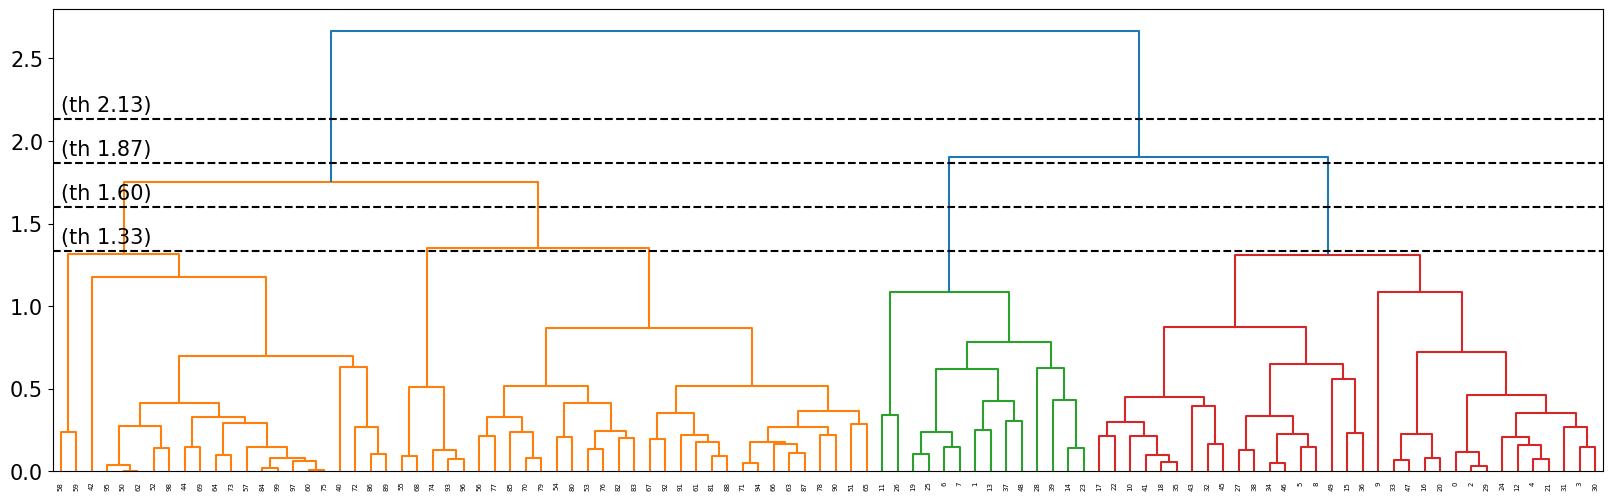

In [18]:
X = pdist(train_all, metric='euclidean')
Z = linkage(X, method='average')
fig,ax = plt.subplots(figsize=(20, 6))
dn = dendrogram(Z)
mx = np.max(Z[:,2])
thresholds = [a*mx for a in [0.5, 0.6, 0.7, 0.8]]
for th in thresholds:
    ax.axhline(y = th, c= 'k', label = f'threhold= {th:0.2f}', ls = '--')
    ax.text(x = 5, y = th+0.05, s = f'(th {th:0.2f})')
#plt.legend()

If clusters dont overlap, elements within subcluster should be agglomerated first.<br>
This process holds and continues to the end.<br>
Dendrogramm x-values ('leaves') then should be also ordered from pairs of elements form clusters.

This means that structure of input (cluster1, cluster2) should also be preserved.

* First half of 'leaves' should contain IDs of 50 elements of cluster 1 or cluster 2 and same for other half.<br>
   This representation can be seen on left bar plot. We see thats not the case. left half contains entries below 50, and right half -entries higher than 50.<br>
   This means they are misrepresented.

* You can do inverse analysis. In true ordered cluster ID list, tell which position in 'leaves' they take.<br>
   This can be seen on right bar plot. Again we expect first half of data be placed on left or right half of dendrogram, which is not the case due to cluster overlap.

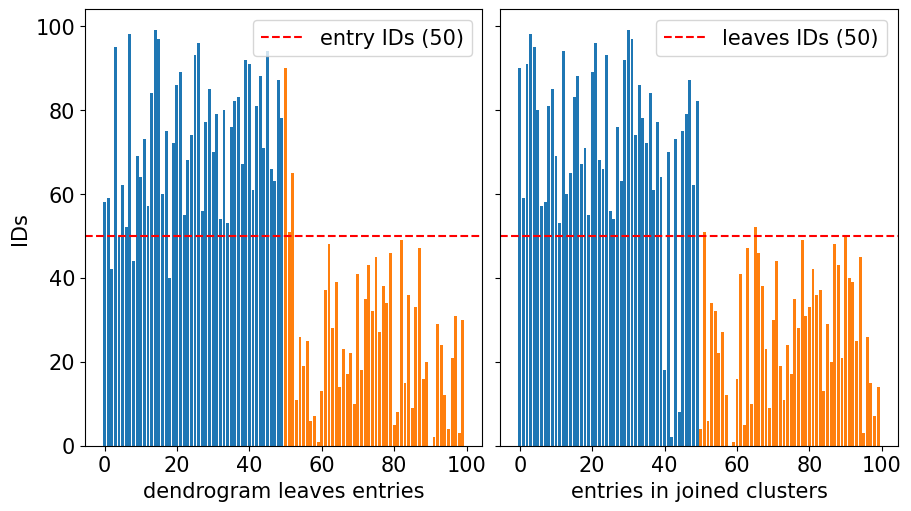

In [19]:
fig,ax = plt.subplots(1,2,figsize=(9, 5), sharex=True, sharey=True, layout='constrained')
leaves = dn['leaves']

ax[0].bar(range(2*n1)[:n1],leaves[:n1])
ax[0].bar(range(2*n1)[n1:],leaves[n1:])
ax[0].axhline(y=50, ls = '--', c= 'r', label = 'entry IDs (50)')
ax[0].set_xlabel('dendrogram leaves entries')
ax[0].set_ylabel('IDs')
ax[0].legend()

# to calc inverse- sort entry IDs by values of leaves
entries = sorted(list(range(2*n1)),key=lambda x: leaves[x])
ax[1].bar(range(2*n1)[:n1],entries[:n1])
ax[1].bar(range(2*n1)[n1:],entries[n1:])
ax[1].axhline(y=50, ls = '--', c= 'r', label = 'leaves IDs (50)')
ax[1].set_xlabel('entries in joined clusters');
ax[1].legend()

# Plot different clustering outcomes
fcluster() allows to return clusters from linkage() for specified threshold

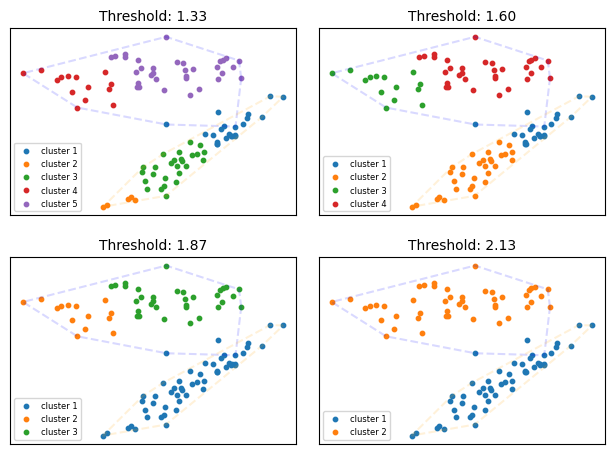

In [20]:
fig, ax = plt.subplots(2,2,tight_layout=True, sharex=True, sharey=True)
ax = ax.flatten()
for i,th in enumerate(thresholds):
    clusters = fcluster(Z, th, criterion='distance')
    num_clusters = np.max(clusters)
    cluster_IDs = np.arange(1, num_clusters + 1, 1)
    for ID in cluster_IDs:
        mask = clusters == ID
        ax[i].scatter(*train_all[mask].T, label= f'cluster {ID}', s = 10)

    ax[i].plot(*hull1t.T.reshape(2,-1), c = 'b', ls = '--', alpha = 0.15)
    ax[i].plot(*hull2t.T.reshape(2,-1), c = 'orange', ls = '--', alpha = 0.15)
    ax[i].legend(fontsize = 6)
    ax[i].set_title(f'Threshold: {th:0.2f}',fontsize = 10)
    ax[i].set_xticks([])
    ax[i].set_yticks([]) 